In [1]:
import sys 
sys.path.append('../scripts/')
from dynamic_programming import *

In [2]:
class BeliefDynamicProgramming(DynamicProgramming): 
    def __init__(self, widths, goal, puddles, time_interval, sampling_num, puddle_coef=100.0, \
                 lowerleft=np.array([-4, -4]).T, upperright=np.array([4, 4]).T, dev_borders=[0.1,0.2,0.4,0.8]): 
        super().__init__(widths, goal, puddles, time_interval, sampling_num, puddle_coef, lowerleft, upperright)
        
        self.index_nums = np.array([*self.index_nums, len(dev_borders) + 1])
        nx, ny, nt, nh = self.index_nums
        self.indexes = list(itertools.product(range(nx), range(ny), range(nt), range(nh)))
        
        self.value_function, self.final_state_flags =  self.init_belief_value_function()
        self.policy = np.zeros(np.r_[self.index_nums,2]) 
    
    def init_belief_value_function(self): 
        v = np.empty(self.index_nums)
        f = np.zeros(self.index_nums) 
        
        for index in self.indexes:
            f[index] = self.belief_final_state(np.array(index).T)
            v[index] = self.goal.value if f[index] else -100.0
                
        return v, f
        
    def belief_final_state(self, index):
        x_min, y_min, _ = self.pose_min + self.widths*index[0:3] 
        x_max, y_max, _ = self.pose_min + self.widths*(index[0:3] + 1) 
        
        corners = [[x_min, y_min, _], [x_min, y_max, _], [x_max, y_min, _], [x_max, y_max, _] ] 
        return all([self.goal.inside(np.array(c).T) for c in corners ]) and index[3] == 0
    
    def action_value(self, action, index, out_penalty=True):  ###beliefdp2
        value = 0.0
        for delta, prob in self.state_transition_probs[(action, index[2])]: 
            after, out_reward = self.out_correction(np.array(index[0:3]).T + delta) #indexを4次元から3次元に
            after = tuple([*after, 0])                                                                     #エントロピーのインデックスを加える（とりあえず0で）
            reward = - self.time_interval * self.depths[(after[0], after[1])] * self.puddle_coef - self.time_interval + out_reward*out_penalty
            value += (self.value_function[after] + reward) * prob

        return value

In [3]:
puddles = [Puddle((-2, 0), (0, 2), 0.1), Puddle((-0.5, -2), (2.5, 1), 0.1)]
dp = BeliefDynamicProgramming(np.array([0.2, 0.2, math.pi/18]).T, Goal(-3,-3), puddles, 0.1, 10)  #クラスを派生したものに

In [4]:
delta = dp.value_iteration_sweep()  ###beliefdp2exec

<IPython.core.display.Javascript object>


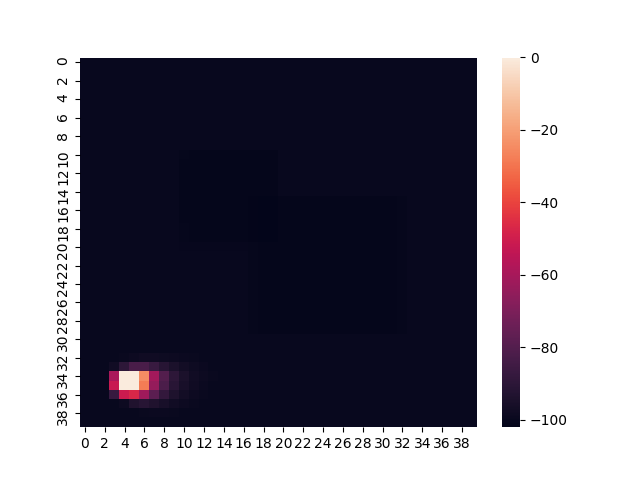

In [5]:
import seaborn as sns
v = dp.value_function[:, :, 18, 1]
sns.heatmap(np.rot90(v), square=False)
plt.show()